In [141]:
import numpy as np
import opendatasets as od
od.download("https://www.kaggle.com/datasets/dextershepherd/non-linear-optical-tactile-data")
datapath_="/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/"
import sys
sys.path.insert(1, '/its/home/drs25/Robot_foot')
from Robot_foot import opticalSensor, ImageDataPreprocessor
from tempfile import mkdtemp
import os
import matplotlib.pyplot as plt
import cv2
from models import *
from sklearn.ensemble import RandomForestClassifier
from data_format import *
import joblib  # For saving and loading the model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_loader import loaded
np.set_printoptions(precision=2, suppress=False)

Skipping, found downloaded files in "./non-linear-optical-tactile-data" (use force=True to force download)


## load in data

In [142]:
#test on model
Xo=np.load(datapath_+"X_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
yo=np.load(datapath_+"y_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
print("pressure loaded")
Xp=np.load(datapath_+"X_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
yp=np.load(datapath_+"y_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
print("circle loaded")

tactip = opticalSensor()
print(Xo.shape,yo.shape)

pressure loaded
circle loaded


/its/home/drs25/Robot_foot/Robot_foot/__init__.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(model_dir,"mymodel_lst

(666, 50, 110, 120) (666,)


## convert data

In [96]:
def load_files_memory_efficient(directory, type_="circle", temp_dir=None):
    if temp_dir is None:
        temp_dir = mkdtemp()
    
    # First pass: collect labels and create mapping
    file_paths = []
    labels=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'cotton', 'Plastic', 'Flat', 'foamf', 'foamg', 'bubble', 'foame', 'jeans', 'Leather']
    keys = {labels[i].lower():i for i in range(len(labels))}
    for item in os.listdir(directory):
        full_path = os.path.join(directory, item)
        if not os.path.isfile(full_path):
            continue
            
        filename = os.path.basename(full_path)
        newlabel = filename.split("_")[2].lower()
        if newlabel not in keys:
            keys[newlabel] = len(keys)
        file_paths.append(full_path)
    print(keys)
    # Initialize memory-mapped arrays for final output
    sample_file = np.load(file_paths[0])
    if type_ == "circle" or type_ == "pressure":
        sample_file = sample_file[:, :, :len(np.arange(10, 100, 10))]
    
    sample_shape = (1 * 2 * len(np.arange(10, 100, 10)), 50, *sample_file.shape[4:])
    
    # Create memory-mapped arrays for data and labels
    data_memmap_path = os.path.join(temp_dir, 'data_memmap.dat')
    label_memmap_path = os.path.join(temp_dir, 'label_memmap.dat')
    
    # Calculate total size needed
    total_samples = 0
    for file_path in file_paths:
        data = np.load(file_path)
        if type_ == "circle" or type_ == "pressure":
            data = data[:, :, :len(np.arange(10, 100, 10))]
        total_samples += data.shape[0] * 2 * len(np.arange(10, 100, 10))
    
    # Initialize memmap files
    data_memmap = np.memmap(data_memmap_path, dtype=np.uint8, mode='w+', 
                           shape=(total_samples, *sample_shape[1:]))
    label_memmap = np.memmap(label_memmap_path, dtype=np.uint8, mode='w+',
                            shape=(total_samples,))
    
    # Second pass: process files one at a time
    current_idx = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        #print("Processing:", filename)
        
        data = np.load(file_path).astype(np.uint8)
        newlabel = filename.split("_")[2].lower()
        num = keys[newlabel]
        
        if type_ == "circle" or type_ == "pressure":
            data = data[:, :, :len(np.arange(10, 100, 10))]
        
        data = data.reshape((1 * 2 * len(np.arange(10, 100, 10)), 50, *data.shape[4:]))
        num_samples = data.shape[0]
        
        # Write to memmap
        data_memmap[current_idx:current_idx + num_samples] = data
        label_memmap[current_idx:current_idx + num_samples] = np.ones((num_samples,)) * num
        
        current_idx += num_samples
    
    # Flush changes to disk
    data_memmap.flush()
    label_memmap.flush()
    
    # Reload as regular arrays (or keep as memmap if you prefer)
    final_data = np.array(data_memmap)
    final_labels = np.array(label_memmap)
    
    # Clean up temporary files
    del data_memmap
    del label_memmap
    try:
        os.remove(data_memmap_path)
        os.remove(label_memmap_path)
    except:
        pass
    
    return final_data, final_labels

In [138]:
prcess=ImageDataPreprocessor()
x,y=load_files_memory_efficient("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure","pressure")
Xo_new=prcess.process_data(x)
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/X_nonlinear_pressure1",Xo_new.astype(np.uint8))
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/y_nonlinear_pressure1",y.astype(np.uint8))

prcess=ImageDataPreprocessor()
x,y=load_files_memory_efficient("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/circle/circle","circle")
Xo_new=prcess.process_data(x)
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/X_nonlinear_circle1",Xo_new.astype(np.uint8))
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/y_nonlinear_circle1",y.astype(np.uint8))

del x,y

{'carpet': 0, 'lacedmatt': 1, 'wool': 2, 'cork': 3, 'felt': 4, 'longcarpet': 5, 'cotton': 6, 'plastic': 7, 'flat': 8, 'foamf': 9, 'foamg': 10, 'bubble': 11, 'foame': 12, 'jeans': 13, 'leather': 14, 'cotten': 15}


## retrain with some non linear

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 20 
Image: (110, 120)
Memory needed: 2.21 GB


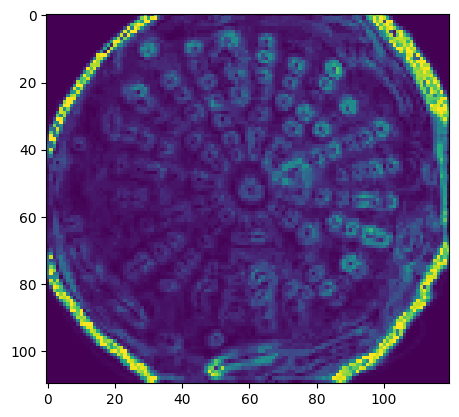

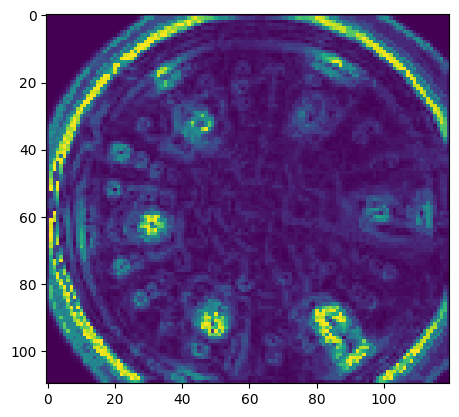

(135000, 4, 110, 120) (666, 10, 110, 120) (666,) (135000,)
(135000, 4, 110, 120) (135000,)


In [143]:
data=loaded()
data.applySobel()
data.augment(t=4)
plt.imshow(data.X[0][0])
plt.show()
plt.imshow(Xo[0][0])
plt.show()
print(data.X.shape,Xo[:,:10].shape,yo.shape,data.y.shape)
"""data.X=np.concatenate([data.X,Xo[:,:20]])
data.y=np.concatenate([data.y,yo])
data.X=np.concatenate([data.X,Xp[:,:20]])
data.y=np.concatenate([data.y,yp])"""
print(data.X.shape,data.y.shape)
data.shuffle()
data.X=data.X[:35000]
data.y=data.y[:35000]

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
frm=0
to=10
n=15000
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
train_loader,test_loader=org_data(data, (len(data.X),abs(frm-to),data.X.shape[2]*data.X.shape[3]),n=n)
model,history=runLSTM(train_loader,0,4,num_epochs=150)
torch.save(model.state_dict(),"/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_lstm_augment")
print(calc(model,test_loader))
print(calc(model,train_loader))


LOADED DATASET...
Memory left 23.59 GB
(15000, 10, 110, 120) (15000, 10, 13200)
Using 14.75 GB
torch.Size([15000, 10, 13200])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)#.to(device)


Epoch [1/150], Step [300/300], Loss: 812.2329
Epoch [11/150], Step [300/300], Loss: 804.4502
Epoch [21/150], Step [300/300], Loss: 602.6724
Epoch [31/150], Step [300/300], Loss: 509.8308
Epoch [41/150], Step [300/300], Loss: 438.8275
Epoch [51/150], Step [300/300], Loss: 395.6830
Epoch [61/150], Step [300/300], Loss: 266.9890
Epoch [71/150], Step [300/300], Loss: 180.7059
Epoch [81/150], Step [300/300], Loss: 126.4804
Epoch [91/150], Step [300/300], Loss: 86.3310
Epoch [101/150], Step [300/300], Loss: 53.2347
Epoch [111/150], Step [300/300], Loss: 28.1256
Epoch [121/150], Step [300/300], Loss: 17.3612
Epoch [131/150], Step [300/300], Loss: 12.0412
Epoch [141/150], Step [300/300], Loss: 9.3447
Finished Training
Accuracy: 98.66337788740375 %
0.9866337788740376
Accuracy: 99.34083882634312 %
0.9934083882634311


In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
frm=0
to=10
n=15000
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
train_loader,test_loader=org_data(data, (len(data.X),1, abs(frm-to)*data.X.shape[2],data.X.shape[3]),n=n)
model,history=run(train_loader,0,4,num_epochs=100)
torch.save(model.state_dict(),"/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_CNN_augment")
print(calc(model,test_loader))
print(calc(model,train_loader))


LOADED DATASET...
Memory left 23.59 GB
(15000, 10, 110, 120) (15000, 1, 1100, 120)
Using 14.75 GB
torch.Size([15000, 1, 1100, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)#.to(device)


Epoch [1/150], Step [300/300], Loss: 812.4524
Epoch [11/150], Step [300/300], Loss: 176.5791
Epoch [21/150], Step [300/300], Loss: 53.5175
Epoch [31/150], Step [300/300], Loss: 25.1687
Epoch [41/150], Step [300/300], Loss: 11.9927
Epoch [51/150], Step [300/300], Loss: 5.7700
Epoch [61/150], Step [300/300], Loss: 1.4406
Epoch [71/150], Step [300/300], Loss: 0.6139
Epoch [81/150], Step [300/300], Loss: 1.5867
Epoch [91/150], Step [300/300], Loss: 0.1395
Epoch [101/150], Step [300/300], Loss: 0.1112
Epoch [111/150], Step [300/300], Loss: 0.0945
Epoch [121/150], Step [300/300], Loss: 0.0815
Epoch [131/150], Step [300/300], Loss: 0.0681
Epoch [141/150], Step [300/300], Loss: 0.0601
Finished Training
Accuracy: 99.73000899970002 %
0.9973000899970001
Accuracy: 99.99916667361106 %
0.9999916667361105


## testing time

### cnn

In [23]:
10 * (440 // 4) * (120 // 4)

33000

In [24]:
frm=0
to=10
n=150
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
Xo_new=(Xo-np.mean(Xo))/(np.max(Xo)-np.min(Xo))
X_data=data.X.reshape((len(data.X),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
print(X_data.shape,X_data.shape[2],X_data.shape[3])
model = SimpleCNN(X_data.shape[2],X_data.shape[3],15).to(device)
model.load_state_dict(torch.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_CNN_augment"))
model.eval()

Xo_new=Xo_new[:n,frm:to,:]
Xo_new=Xo_new.reshape((n,1,Xo_new.shape[1]*Xo_new.shape[2],Xo_new.shape[3])).astype(np.float32)
test_array=torch.tensor(Xo_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear circle:",len(acc[acc==True])/len(preds) *100,"%")


test_array=torch.tensor((X_data.astype(np.float32)-np.mean(X_data))/(np.max(X_data)-np.min(X_data))).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==data.y[0:n]
print("Normal dataset:",len(acc[acc==True])/len(preds) *100,"%")

Xp_new=(Xp-np.mean(Xp))/(np.max(Xp)-np.min(Xp))
Xp_new=Xp_new[:n,frm:to]
Xp_new=Xp_new.reshape((n,1,Xp_new.shape[1]*Xp_new.shape[2],Xp_new.shape[3])).astype(np.float32)
Xp_new=Xp_new[:,0:4,:]
test_array=torch.tensor(Xp_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear pressure:",len(acc[acc==True])/len(preds) *100,"%")

ValueError: cannot reshape array of size 7920000 into shape (150,1,1100,120)

### lstm

In [23]:
frm=0
to=4
n=150
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
Xo_new=(Xo-np.mean(Xo))/(np.max(Xo)-np.min(Xo))
X_data=data.X.reshape((len(data.X),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
model = SimpleLSTM(X_data.shape[2],350,15,3).to(device).to(device)
model.load_state_dict(torch.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_lstm_augment"))
model.eval()
Xo_new=Xo_new.reshape((len(Xo_new),Xo_new.shape[1],-1)).astype(np.float32)
Xo_new=Xo_new[:,0:4,:]
test_array=torch.tensor(Xo_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear circle:",len(acc[acc==True])/len(preds) *100,"%")
test_array=torch.tensor((X_data.astype(np.float32)-np.mean(X_data))/(np.max(X_data)-np.min(X_data))).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==data.y[0:n]
print("Normal dataset:",len(acc[acc==True])/len(preds) *100,"%")

Xp_new=(Xp-np.mean(Xp))/(np.max(Xp)-np.min(Xp))
Xp_new=Xp_new.reshape((len(Xp_new),Xp_new.shape[1],-1)).astype(np.float32)
Xp_new=Xp_new[:,0:4,:]
test_array=torch.tensor(Xp_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear pressure:",len(acc[acc==True])/len(preds) *100,"%")

/tmp/ipykernel_2576403/87840069.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/n

Non linear circle: 0.0 %
Normal dataset: 74.66666666666667 %
Non linear pressure: 0.0 %


### random forest classifier??

In [14]:
def min_max_scale(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

In [17]:
linear=data.X[:,:4,:,:].reshape((len(data.X),-1))
circle=Xo[:,:4,:].reshape((len(Xo),-1))
pressure=Xp[:,:4,:].reshape((len(Xp),-1))
X_normalized = min_max_scale(linear)
Xo_normalized = min_max_scale(circle)
Xp_normalized = min_max_scale(pressure)

print(np.average(X_normalized))
print(np.average(Xo_normalized))
print(np.average(Xp_normalized ))

print(np.average(Xp))
print(np.average(Xo))
print(np.average(data.X))
del linear
del circle
del pressure

0.12523414802011587
0.08002247523816144
0.03673340541152001
9.37910918740248
20.494407455182454
31.93470774512987


In [19]:

"""flattened=Xp[:,:10,:]
flattened=flattened.reshape((len(Xp),-1))"""
X_train, X_test, y_train, y_test = train_test_split(X_normalized, data.y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=50)
rfc.fit(X_train, y_train)

joblib.dump(rfc, "/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model_linear.pkl")


['/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model_linear.pkl']

In [ ]:
rfc = joblib.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model.pkl")

In [21]:
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Classifier Test:", accuracy*100)

y_pred = rfc.predict(Xo_normalized)
accuracy = accuracy_score(yo, y_pred)
print("Accuracy of Random Forest Classifier on non linear circle:", accuracy *100,"%")

y_pred = rfc.predict(Xp_normalized)
accuracy = accuracy_score(yp, y_pred)
print("Accuracy of Random Forest Classifier on non linear pressure:", accuracy *100,"%")

Accuracy of Random Forest Classifier Test: 99.62857142857143
Accuracy of Random Forest Classifier on non linear circle: 0.0 %
Accuracy of Random Forest Classifier on non linear pressure: 7.452574525745257 %


In [17]:
print("\nClassification Report:")
y_pred = rfc.predict(Xo_reshaped)
print(classification_report(yo, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.06      0.02      0.03        54
         1.0       0.00      0.00      0.00        54
         2.0       0.00      0.00      0.00        54
         3.0       0.00      0.00      0.00        54
         4.0       0.00      0.00      0.00        36
         5.0       0.08      0.50      0.14        54
         6.0       0.00      0.00      0.00        54
         7.0       0.00      0.00      0.00        54
         8.0       0.00      0.00      0.00        54
         9.0       0.00      0.00      0.00        54
        10.0       0.00      0.00      0.00        54
        11.0       0.00      0.00      0.00        36
        12.0       0.00      0.00      0.00        54
        13.0       0.00      0.00      0.00         0

    accuracy                           0.04       666
   macro avg       0.01      0.04      0.01       666
weighted avg       0.01      0.04      0.01       666



/its/home/drs25/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/its/home/drs25/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/its/home/drs25/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/its/home/drs25/.loca

### SVM

In [29]:
temp = data.X[0:3000, 0:10, :, :].copy()
flattened = temp.reshape((len(temp), -1))
X_train, X_test, y_train, y_test = train_test_split(flattened, data.y, test_size=0.2, random_state=42)

# Train an SVM classifier (you can change kernel='linear' or 'poly' as needed)
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# Save the model
joblib.dump(svm_clf, "/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/svm_model_nonlinear_all.pkl")

In [ ]:
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of SVM Test:", accuracy*100)


Xo_reshaped=Xo[:,0:10,:,:].reshape((len(Xo),-1))
y_pred = svm_clf.predict(Xo_reshaped)
accuracy = accuracy_score(yo, y_pred)
print("Accuracy of SVM on non linear circle:", accuracy *100,"%")

Xp_reshaped=Xp[:,0:10,:,:].reshape((len(Xp),-1))
y_pred = svm_clf.predict(Xp_reshaped)
accuracy = accuracy_score(yp, y_pred)
print("Accuracy of SVM on non linear pressure:", accuracy *100,"%")

: 

In [6]:
Xo_new=(Xo-np.mean(Xo))/(np.max(Xo)-np.min(Xo))
tactip.model=model
for start,end in zip(range(0,len(Xo)-200,200),range(200,len(Xo),200)):
    correct=0
    preds=tactip.predict_texture_multi(Xo_new[start:end,:10])
    acc=preds==yo[start:end]
    correct+=len(acc[acc==True])

print(correct/len(Xo) *100,"%")

6.456456456456457 %


(1, 2, 10, 50, 480, 640, 3)


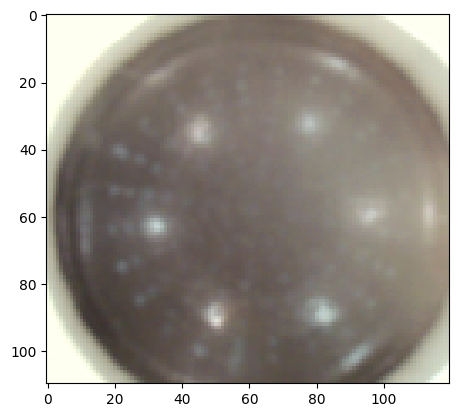

In [ ]:
import cv2
data=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/circle/circle/circle_TT_Bubble_P60.npy")
print(data.shape)
crop=[60,180,40,150]
compression_dim=0.4
new_dim=(int(640*compression_dim),int(480*compression_dim))
image=data[0][0][0][0]
image = cv2.resize(image,new_dim,interpolation=cv2.INTER_AREA)
plt.imshow(image[crop[2]:crop[3],crop[0]:crop[1]])
plt.show()

# SO(3)

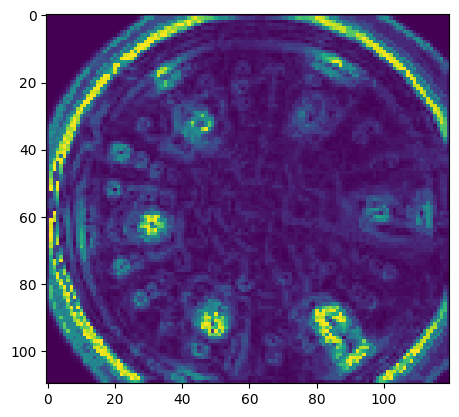

In [3]:
from scipy.spatial.transform import Rotation as R
def rotation_matrices_to_lie_algebra(R_matrices):
    samples, time_steps, _, _ = R_matrices.shape
    lie_vectors = np.zeros((samples, time_steps, 3))  # axis-angle format
    
    for i in range(samples):
        for t in range(time_steps):
            r = R.from_matrix(R_matrices[i, t])
            lie_vectors[i, t] = r.as_rotvec()  # Lie algebra representation
    return lie_vectors

image=Xo[0][0]


# autoencoder

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNAutoencoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=32, input_size=(28, 28)):
        super(CNNAutoencoder, self).__init__()
        self.input_size = input_size
        self.input_channels = input_channels
        
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Calculate the flattened size automatically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, *input_size)
            dummy_output = self.encoder_conv(dummy_input)
            self.flattened_size = dummy_output.numel() // dummy_output.shape[0]  # Get per-sample size
        
        # Encoder fully connected layer
        self.encoder_fc = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder fully connected layer
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)
        
        # Calculate the shape needed for unflattening
        self.decoder_unflatten_shape = dummy_output.shape[1:]  # [64, H', W']
        
        # Decoder transposed convolutional layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder_conv(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # Flatten
        z = self.encoder_fc(x)
        
        # Decode
        x = self.decoder_fc(z)
        x = x.view(batch_size, *self.decoder_unflatten_shape)  # Unflatten to conv output shape
        x = self.decoder_conv(x)
        
        # Ensure output matches input size
        if x.shape[-2:] != self.input_size:
            x = F.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
        
        return x
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        return self.encoder_fc(x)
    
    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(z.size(0), *self.decoder_unflatten_shape)
        x = self.decoder_conv(x)
        
        if x.shape[-2:] != self.input_size:
            x = F.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
        
        return x

e=CNNAutoencoder(1,input_size=(4*110,120))
x = torch.randn(1, 1, 4*110, 120)  # batch=1
e.forward(x)

tensor([[[[0.4160, 0.4175, 0.4118,  ..., 0.4194, 0.4136, 0.4186],
          [0.4142, 0.4155, 0.4085,  ..., 0.4112, 0.4149, 0.4066],
          [0.4124, 0.4178, 0.4105,  ..., 0.4194, 0.4143, 0.4192],
          ...,
          [0.4117, 0.4124, 0.4129,  ..., 0.4149, 0.4141, 0.4067],
          [0.4128, 0.4222, 0.4139,  ..., 0.4194, 0.4128, 0.4180],
          [0.4169, 0.4265, 0.4175,  ..., 0.4244, 0.4145, 0.4129]]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
Xo=np.load(datapath_+"X_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
yo=np.load(datapath_+"y_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
print("pressure loaded")
Xp=np.load(datapath_+"X_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
yp=np.load(datapath_+"y_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
print("circle loaded")

In [211]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Example parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAutoencoder(1,input_size=(4*110,120)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Assume you have loaded your data as a torch tensor: shape (N, T, C, H, W)
# PyTorch expects (N, C, T, H, W) for 3D convs
def prepare_dataloader(data_tensor, batch_size=16):
    #data_tensor = data_tensor.permute(0, 2, 1, 3, 4)  # (N, C, T, H, W)
    dataset = TensorDataset(data_tensor, data_tensor)  # Input == Target for autoencoder
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dx=data.X.reshape((len(data.X),1,data.X.shape[1]*data.X.shape[2],data.X.shape[3]))
Xo_=Xo[:,:4]
Xp_=Xp[:,:4]
Xo_=Xo_.reshape((len(Xo_),1,Xo_.shape[1]*Xo_.shape[2],Xo_.shape[3]))
Xp_=Xp_.reshape((len(Xp_),1,Xp_.shape[1]*Xp_.shape[2],Xp_.shape[3]))
print(dx.shape,Xo_.shape,Xp_.shape)
vals=np.concatenate([dx,Xo_,Xp_],axis=0)
# Replace with your data loading logi
train_loader = prepare_dataloader(torch.tensor(vals).float() / 255.0)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


(35000, 1, 440, 120) (666, 1, 440, 120) (738, 1, 440, 120)


# electrical

In [97]:
path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-electrical-tactile-data/pressure/"
x,y=load_files_memory_efficient(path,"pressure")
np.save(datapath_+"X_PTnonlinear_pressure",x)
np.save(datapath_+"y_PTnonlinear_pressure",y)
path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-electrical-tactile-data/circle/"
x,y=load_files_memory_efficient(path,"circle")
np.save(datapath_+"X_PTnonlinear_circle",x)
np.save(datapath_+"y_PTnonlinear_circle",y)

{'carpet': 0, 'lacedmatt': 1, 'wool': 2, 'cork': 3, 'felt': 4, 'longcarpet': 5, 'cotton': 6, 'plastic': 7, 'flat': 8, 'foamf': 9, 'foamg': 10, 'bubble': 11, 'foame': 12, 'jeans': 13, 'leather': 14}
{'carpet': 0, 'lacedmatt': 1, 'wool': 2, 'cork': 3, 'felt': 4, 'longcarpet': 5, 'cotton': 6, 'plastic': 7, 'flat': 8, 'foamf': 9, 'foamg': 10, 'bubble': 11, 'foame': 12, 'jeans': 13, 'leather': 14}


In [98]:
xo=np.load(datapath_+"X_PTnonlinear_circle.npy")
yo=np.load(datapath_+"y_PTnonlinear_circle.npy")

xp=np.load(datapath_+"X_PTnonlinear_pressure.npy")
yp=np.load(datapath_+"y_PTnonlinear_pressure.npy")

xo=xo[:,:20,8:12] #get correct sensors
xp=xp[:,:20,8:12] #get correct sensors

xo=(xo*3.3)/65536 *10
xp=(xp*3.3)/65536 *10
print(xo.shape)
print(xp.shape)

(702, 20, 4)
(702, 20, 4)


In [99]:
data = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data:
    X=data[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data:
    y=data[array_name]
print(X.shape,y.shape)
X=X[:,:,8:12]

(3000, 20, 16) (3000,)


In [119]:
Xo_normalized=xo[:,:20].reshape((len(xo),-1))
Xp_normalized=xp[:,:20].reshape((len(xp),-1))
data_norm=X[:,:20].reshape((len(X),-1))
indices=np.where(np.sum(Xo_normalized,axis=1)==0)
Xo_filtered = np.delete(Xo_normalized, indices, axis=0)
yo_filt = np.delete(yo, indices, axis=0)
indices=np.where(np.sum(Xp_normalized,axis=1)==0)
yp_filt = np.delete(yp, indices, axis=0)

print(Xo_filtered.shape,Xp_filtered.shape)

(351, 80) (351, 80)


1.79117533203125
0.03198445801042084
0.03183097513312967


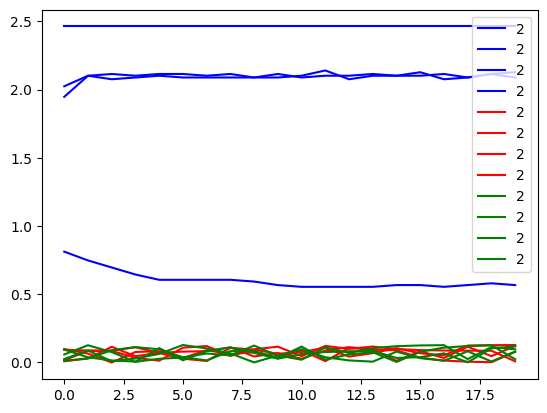

In [110]:
print(np.average(data_norm))
print(np.average(Xo_normalized))
print(np.average(Xp_normalized))
class_=2
inda=np.where(y==class_)[0][0]
indb=np.where(yo==class_)[0][0]
indc=np.where(yp==class_)[0][0]
plt.plot(X[inda,:,],c="b",label=str(y[inda]))
plt.plot(xo[indb,:,],c="r",label=str(yo[indb]))
plt.plot(xp[indc,:,],c="g",label=str(yp[indc]))
plt.legend(loc="upper right")
plt.show()

## RFC

In [136]:
AV=[]
"""flattened=Xp[:,:10,:]
flattened=flattened.reshape((len(Xp),-1))"""
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(np.concatenate([data_norm,Xo_filtered,Xp_filtered]), np.concatenate([y,yo_filt,yp_filt]), test_size=0.2, random_state=42)

    rfc = RandomForestClassifier(random_state=42, n_estimators=50)
    rfc.fit(X_train, y_train)

    #joblib.dump(rfc, "/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model_linear.pkl")
    y_pred = rfc.predict(X_train)
    accuracy0 = accuracy_score(y_train, y_pred)

    y_pred = rfc.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred)
    #print("Accuracy of Random Forest Classifier Test:", accuracy1*100)

    y_pred = rfc.predict(Xo_filtered)
    accuracy2 = accuracy_score(yo_filt, y_pred)
    #print("Accuracy of Random Forest Classifier on non linear circle:", accuracy2 *100,"%")

    y_pred = rfc.predict(Xp_filtered)
    accuracy3 = accuracy_score(yp_filt, y_pred)
    #print("Accuracy of Random Forest Classifier on non linear pressure:", accuracy3 *100,"%")
    AV.append([accuracy0,accuracy1,accuracy2,accuracy3])
AV=np.array(AV)
std=np.std(AV,axis=0)
AV=np.average(AV,axis=0)

print("Accuracies:\n\tTest:",AV[1],"\n\tXo:",AV[2],"\n\tXp:",AV[3],"\n\tTrain:",AV[0])
print("std:",std*100)

Accuracies:
	Test: 0.7773279352226722 
	Xo: 0.8376068376068379 
	Xp: 0.8575498575498577 
	Train: 1.0
std: [0.00e+00 1.11e-14 2.22e-14 1.11e-14]
